## Acquire and Prep

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import sklearn.linear_model
from sklearn.model_selection import train_test_split

import env
import split_scale

from math import sqrt
%matplotlib inline

**SQL query to use for the MVP model**

In [2]:
query = """
SELECT 
bathroomcnt AS bath_count,
bedroomcnt AS bedroom_count,
calculatedfinishedsquarefeet AS sqft,
fips,
taxvaluedollarcnt AS assessed_tax_value,                                                                            
(taxamount / taxvaluedollarcnt) AS tax_rate
FROM properties_2017
JOIN predictions_2017 AS pr USING(`parcelid`)
WHERE (transactiondate >= '2017-05-01' AND transactiondate <= '2017-06-30') AND
propertylandusetypeid = 261;"""

In [3]:
#add get_db_url to wrangle.py
URL = env.get_db_url("zillow")

In [4]:
zillow = pd.read_sql(query, URL)

**Take a peek at the data**

In [5]:
zillow.sample(4)

,bath_count,bedroom_count,sqft,fips,assessed_tax_value,tax_rate
10168,3.5,4.0,3620.0,6111.0,1014224.0,0.011290
10526,2.0,4.0,1352.0,6037.0,76323.0,0.022196
6752,4.0,4.0,2727.0,6037.0,320841.0,0.014139
2147,3.5,6.0,4072.0,6059.0,770190.0,0.010688


**Bring in the fips**

In [6]:
FIPS = pd.read_csv("FIPS.txt", sep="\t")

In [7]:
FIPS

,FIPS,Name,State
0,1001,Autauga,AL
1,1003,Baldwin,AL
2,1005,Barbour,AL
3,1007,Bibb,AL
4,1009,Blount,AL
...,...,...,...
3227,72151,Yabucoa,PR
3228,72153,Yauco,PR
3229,78010,St. Croix,VI
3230,78020,St. John,VI


In [8]:
zillow = pd.merge(left=zillow, right=FIPS, left_on="fips", right_on="FIPS")

In [9]:
zillow

,bath_count,bedroom_count,sqft,fips,assessed_tax_value,tax_rate,FIPS,Name,State
0,2.0,3.0,1458.0,6037.0,136104.0,0.017045,6037,Los Angeles,CA
1,1.0,2.0,1421.0,6037.0,35606.0,0.015270,6037,Los Angeles,CA
2,2.0,3.0,1650.0,6037.0,614000.0,0.012497,6037,Los Angeles,CA
3,1.0,2.0,693.0,6037.0,274237.0,0.011915,6037,Los Angeles,CA
4,0.0,0.0,1378.0,6037.0,168828.0,0.012648,6037,Los Angeles,CA
...,...,...,...,...,...,...,...,...,...
15031,2.0,3.0,1575.0,6111.0,506000.0,0.010707,6111,Ventura,CA
15032,2.0,3.0,1645.0,6111.0,230986.0,0.012363,6111,Ventura,CA
15033,2.0,3.0,1308.0,6111.0,255407.0,0.010919,6111,Ventura,CA
15034,2.5,4.0,2314.0,6111.0,485364.0,0.019674,6111,Ventura,CA


In [10]:
zillow.rename(columns = {"Name": "county_name"}, inplace = True)

Check the datatypes and info

In [11]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15036 entries, 0 to 15035
Data columns (total 9 columns):
bath_count            15036 non-null float64
bedroom_count         15036 non-null float64
sqft                  15012 non-null float64
fips                  15036 non-null float64
assessed_tax_value    15036 non-null float64
tax_rate              15035 non-null float64
FIPS                  15036 non-null int64
county_name           15036 non-null object
State                 15036 non-null object
dtypes: float64(6), int64(1), object(2)
memory usage: 1.1+ MB


let's check to see how many zeros are in bed and bath

In [12]:
zillow.bath_count.value_counts()

2.0     6182
3.0     3114
1.0     2652
2.5     1155
4.0      671
3.5      302
1.5      240
5.0      233
4.5      217
6.0      102
5.5       65
0.0       40
7.0       25
6.5       15
8.0       14
7.5        4
9.0        3
11.0       1
10.0       1
Name: bath_count, dtype: int64

In [13]:
zillow.bedroom_count.value_counts()

3.0     6668
4.0     4423
2.0     2350
5.0     1158
6.0      183
1.0      177
0.0       42
7.0       27
12.0       3
9.0        2
11.0       1
10.0       1
8.0        1
Name: bedroom_count, dtype: int64

I'm going to drop the zeros in bed and bath to get my MVP out as fast as possible.

- If thime permits later I might try to replace with mean or mode

In [14]:
zillow.bath_count.replace(0, np.nan, inplace=True)

In [15]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15036 entries, 0 to 15035
Data columns (total 9 columns):
bath_count            14996 non-null float64
bedroom_count         15036 non-null float64
sqft                  15012 non-null float64
fips                  15036 non-null float64
assessed_tax_value    15036 non-null float64
tax_rate              15035 non-null float64
FIPS                  15036 non-null int64
county_name           15036 non-null object
State                 15036 non-null object
dtypes: float64(6), int64(1), object(2)
memory usage: 1.1+ MB


In [16]:
zillow.bedroom_count.replace(0, np.nan, inplace=True)

In [17]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15036 entries, 0 to 15035
Data columns (total 9 columns):
bath_count            14996 non-null float64
bedroom_count         14994 non-null float64
sqft                  15012 non-null float64
fips                  15036 non-null float64
assessed_tax_value    15036 non-null float64
tax_rate              15035 non-null float64
FIPS                  15036 non-null int64
county_name           15036 non-null object
State                 15036 non-null object
dtypes: float64(6), int64(1), object(2)
memory usage: 1.1+ MB


In [18]:
zillow.dropna(inplace=True)

In [19]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14989 entries, 0 to 15035
Data columns (total 9 columns):
bath_count            14989 non-null float64
bedroom_count         14989 non-null float64
sqft                  14989 non-null float64
fips                  14989 non-null float64
assessed_tax_value    14989 non-null float64
tax_rate              14989 non-null float64
FIPS                  14989 non-null int64
county_name           14989 non-null object
State                 14989 non-null object
dtypes: float64(6), int64(1), object(2)
memory usage: 1.1+ MB


In [20]:
#drop fips since they have no value to us now
zillow.drop(columns=["fips", "FIPS"], inplace=True)

In [21]:
zillow["tax_percentage"] = zillow.tax_rate * 100

In [22]:
zillow.head()

,bath_count,bedroom_count,sqft,assessed_tax_value,tax_rate,county_name,State,tax_percentage
0,2.0,3.0,1458.0,136104.0,0.017045,Los Angeles,CA,1.704505
1,1.0,2.0,1421.0,35606.0,0.015270,Los Angeles,CA,1.526962
2,2.0,3.0,1650.0,614000.0,0.012497,Los Angeles,CA,1.249705
3,1.0,2.0,693.0,274237.0,0.011915,Los Angeles,CA,1.191477
5,2.0,3.0,1108.0,486866.0,0.012304,Los Angeles,CA,1.230421


In [23]:
zillow.county_name.value_counts()

Los Angeles    9604
Orange         4094
Ventura        1291
Name: county_name, dtype: int64

I'm going to get rid of all outliers to help normalize my data

In [24]:
zillow["home_value_std"] = zillow.assessed_tax_value.std()

In [25]:
zillow.head(2)

,bath_count,bedroom_count,sqft,assessed_tax_value,tax_rate,county_name,State,tax_percentage,home_value_std
0,2.0,3.0,1458.0,136104.0,0.017045,Los Angeles,CA,1.704505,730961.571066
1,1.0,2.0,1421.0,35606.0,0.015270,Los Angeles,CA,1.526962,730961.571066


In [26]:
zillow["home_value_mean"] = zillow.assessed_tax_value.mean()

In [27]:
zillow.head(2)

,bath_count,bedroom_count,sqft,assessed_tax_value,tax_rate,county_name,State,tax_percentage,home_value_std,home_value_mean
0,2.0,3.0,1458.0,136104.0,0.017045,Los Angeles,CA,1.704505,730961.571066,541707.168257
1,1.0,2.0,1421.0,35606.0,0.015270,Los Angeles,CA,1.526962,730961.571066,541707.168257


In [28]:
zillow["anomaly_cut_off"] = zillow["home_value_std"] * 3

In [29]:
zillow["lower_limit"] = zillow["home_value_mean"] - zillow["anomaly_cut_off"]

In [30]:
zillow.head(2)

,bath_count,bedroom_count,sqft,assessed_tax_value,tax_rate,county_name,State,tax_percentage,home_value_std,home_value_mean,anomaly_cut_off,lower_limit
0,2.0,3.0,1458.0,136104.0,0.017045,Los Angeles,CA,1.704505,730961.571066,541707.168257,2.192885e+06,-1.651178e+06
1,1.0,2.0,1421.0,35606.0,0.015270,Los Angeles,CA,1.526962,730961.571066,541707.168257,2.192885e+06,-1.651178e+06


In [31]:
zillow["upper_limit"] = zillow["home_value_mean"] + zillow["home_value_std"]

In [32]:
zillow.head(2)

,bath_count,bedroom_count,sqft,assessed_tax_value,tax_rate,county_name,State,tax_percentage,home_value_std,home_value_mean,anomaly_cut_off,lower_limit,upper_limit
0,2.0,3.0,1458.0,136104.0,0.017045,Los Angeles,CA,1.704505,730961.571066,541707.168257,2.192885e+06,-1.651178e+06,1.272669e+06
1,1.0,2.0,1421.0,35606.0,0.015270,Los Angeles,CA,1.526962,730961.571066,541707.168257,2.192885e+06,-1.651178e+06,1.272669e+06


In [33]:
zillow["is_outlier"] = zillow.assessed_tax_value > zillow.upper_limit

In [34]:
zillow.head(2)

,bath_count,bedroom_count,sqft,assessed_tax_value,tax_rate,county_name,State,tax_percentage,home_value_std,home_value_mean,anomaly_cut_off,lower_limit,upper_limit,is_outlier
0,2.0,3.0,1458.0,136104.0,0.017045,Los Angeles,CA,1.704505,730961.571066,541707.168257,2.192885e+06,-1.651178e+06,1.272669e+06,False
1,1.0,2.0,1421.0,35606.0,0.015270,Los Angeles,CA,1.526962,730961.571066,541707.168257,2.192885e+06,-1.651178e+06,1.272669e+06,False


In [35]:
zillow.is_outlier.value_counts()

False    13928
True      1061
Name: is_outlier, dtype: int64

In [36]:
zillow.is_outlier.replace(True, np.nan, inplace=True)

In [37]:
zillow.shape

(14989, 14)

In [38]:
zillow.dropna(inplace=True)

In [39]:
zillow.shape

(13928, 14)

In [40]:
zillow.head(4)

,bath_count,bedroom_count,sqft,assessed_tax_value,tax_rate,county_name,State,tax_percentage,home_value_std,home_value_mean,anomaly_cut_off,lower_limit,upper_limit,is_outlier
0,2.0,3.0,1458.0,136104.0,0.017045,Los Angeles,CA,1.704505,730961.571066,541707.168257,2.192885e+06,-1.651178e+06,1.272669e+06,0.0
1,1.0,2.0,1421.0,35606.0,0.015270,Los Angeles,CA,1.526962,730961.571066,541707.168257,2.192885e+06,-1.651178e+06,1.272669e+06,0.0
2,2.0,3.0,1650.0,614000.0,0.012497,Los Angeles,CA,1.249705,730961.571066,541707.168257,2.192885e+06,-1.651178e+06,1.272669e+06,0.0
3,1.0,2.0,693.0,274237.0,0.011915,Los Angeles,CA,1.191477,730961.571066,541707.168257,2.192885e+06,-1.651178e+06,1.272669e+06,0.0


In [41]:
zillow.drop(columns=["upper_limit", "is_outlier"], inplace=True)

## Distribution of Tax Rates

In [42]:
la_county = zillow[zillow.county_name == "Los Angeles"]

In [43]:
orange_county = zillow[zillow.county_name == "Orange"]

In [44]:
ventura_county = zillow[zillow.county_name == "Ventura"]

**Let's look at the mean median and mode of each county as well as the overall**

In [45]:
county_mean = pd.DataFrame(zillow.groupby("county_name").tax_rate.mean()) * 100
county_mean.columns = ['Mean Tax Rate %']

In [46]:
county_median = pd.DataFrame(zillow.groupby("county_name").tax_rate.median()) * 100
county_median.columns = ['Median Tax Rate %']

In [47]:
county_max = pd.DataFrame(zillow.groupby("county_name").tax_rate.max()) * 100
county_max.columns = ['Max Tax Rate %']

In [48]:
county_min = pd.DataFrame(zillow.groupby("county_name").tax_rate.min()) * 100
county_min.columns = ['Min Tax Rate %']

In [49]:
county_std = pd.DataFrame(zillow.groupby("county_name").tax_rate.std())
county_std.columns = ['AVG STD of Tax Rates']

In [50]:
summary1 = pd.merge(county_mean, county_median, left_index=True, right_index=True)

In [51]:
summary2 = pd.merge(county_max , county_min , left_index=True, right_index=True)

In [52]:
summary3 = pd.merge(summary1 , summary2 , left_index=True, right_index=True)

In [53]:
pd.merge(summary3 , county_std , left_index=True, right_index=True)

,Mean Tax Rate %,Median Tax Rate %,Max Tax Rate %,Min Tax Rate %,AVG STD of Tax Rates
county_name,,,,,
Los Angeles,1.435175,1.277005,45.288365,0.111118,0.007923
Orange,1.220711,1.159412,10.735031,0.171235,0.003327
Ventura,1.207951,1.127094,29.486491,0.078687,0.008400


LA has some serious outliers and so does Ventura

Text(0.5, 1.0, 'Ventura County')

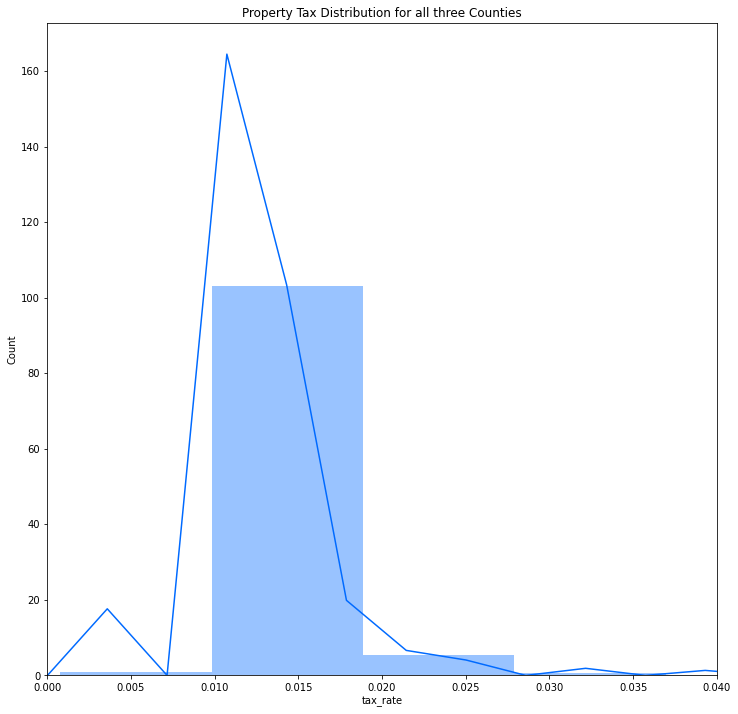

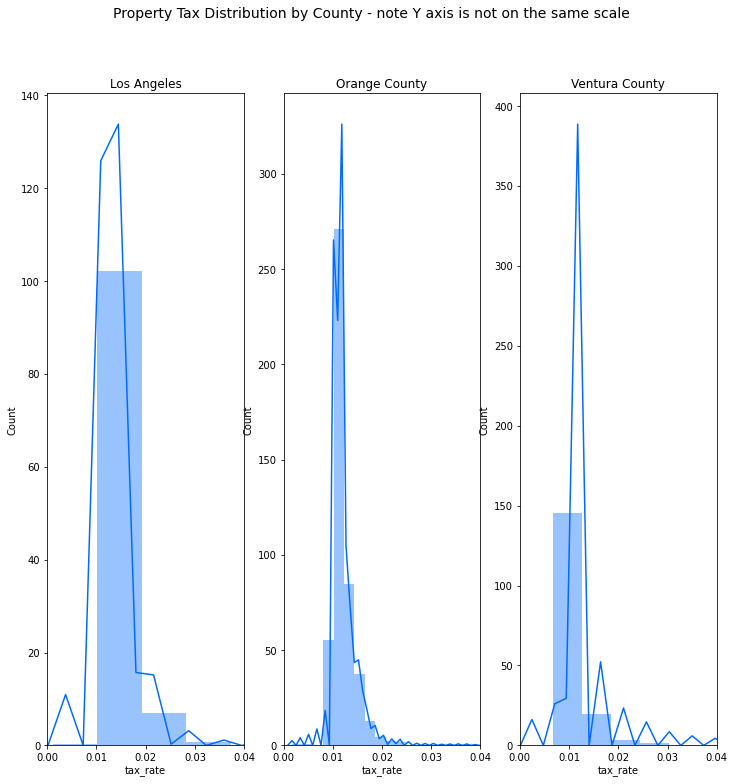

In [54]:
c="#006AFF"

plt.figure(figsize=(12,12))
sns.distplot(zillow.tax_rate, color=c)
plt.xlim(0, 0.04)
plt.ylabel("Count")
plt.title("Property Tax Distribution for all three Counties")

plt.figure(figsize=(12,12))

plt.suptitle('Property Tax Distribution by County - note Y axis is not on the same scale', fontsize=14)

plt.subplot(1, 3, 1)
sns.distplot(la_county.tax_rate, color=c)
plt.xlim(0, 0.04)
plt.ylabel("Count")
plt.title("Los Angeles")

plt.subplot(1, 3, 2)
sns.distplot(orange_county.tax_rate, color=c)
plt.xlim(0, 0.04)
plt.ylabel("Count")
plt.title("Orange County")

plt.subplot(1, 3, 3)
sns.distplot(ventura_county.tax_rate, color=c)
plt.xlim(0, 0.04)
plt.ylabel("Count")
plt.title("Ventura County")


## Split the data

In [55]:
def split_my_data(df, train_pct=0.70, seed=123):
    """
    Takes in a dataframe, training pct amount and seed to split the into testing and training df
    seed will default to 123 if not specified
    train_pct defaults to .7 if not specified
    """
    train, test = train_test_split(df, train_size=train_pct, random_state=seed)
    return train, test

In [56]:
train, test = split_my_data(zillow, .7, 123)

In [57]:
train.sample(4)

,bath_count,bedroom_count,sqft,assessed_tax_value,tax_rate,county_name,State,tax_percentage,home_value_std,home_value_mean,anomaly_cut_off,lower_limit
12269,1.0,2.0,708.0,450390.0,0.012020,Orange,CA,1.202038,730961.571066,541707.168257,2.192885e+06,-1.651178e+06
5044,3.0,4.0,2397.0,196268.0,0.017049,Los Angeles,CA,1.704949,730961.571066,541707.168257,2.192885e+06,-1.651178e+06
2732,2.0,3.0,2003.0,450813.0,0.011068,Los Angeles,CA,1.106780,730961.571066,541707.168257,2.192885e+06,-1.651178e+06
7431,3.0,4.0,1921.0,619972.0,0.011917,Los Angeles,CA,1.191705,730961.571066,541707.168257,2.192885e+06,-1.651178e+06


# Data Exploration

## Initial Hypothesis
- $H_0$ - There will be no linear difference in assessed home values based on sqft, n bedrooms, n of baths
- $H_a$ - There will be a significant linear difference in home values based on the sqft, n bedrooms and n of baths

In [58]:
mvp_df = train[["bath_count", "bedroom_count", "sqft", "assessed_tax_value"]]

In [59]:
X_train = train[["bath_count", "bedroom_count", "sqft"]]

In [60]:
y_train = train.assessed_tax_value

In [61]:
X_train.head()

,bath_count,bedroom_count,sqft
6811,1.0,3.0,1059.0
14770,2.0,4.0,1462.0
8822,2.0,3.0,1258.0
9396,1.0,3.0,1103.0
5697,1.0,2.0,1008.0


In [62]:
y_train.head()

6811     387824.0
14770    441000.0
8822     413368.0
9396     273829.0
5697     148542.0
Name: assessed_tax_value, dtype: float64

In [63]:
alpha = .05

In [64]:
mvp_df.corr()

,bath_count,bedroom_count,sqft,assessed_tax_value
bath_count,1.000000,0.627341,0.825526,0.457774
bedroom_count,0.627341,1.000000,0.636529,0.257421
sqft,0.825526,0.636529,1.000000,0.526800
assessed_tax_value,0.457774,0.257421,0.526800,1.000000


In [65]:
def plot_variable_pairs(dataframe):
    """This function returns a pairplot to help explore relationships"""
    return sns.pairplot(dataframe, kind="reg")

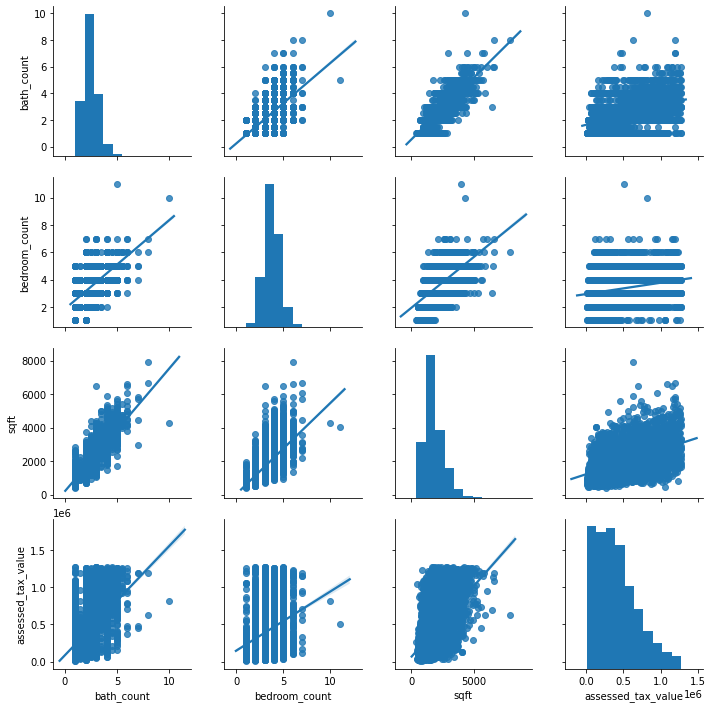

In [66]:
plot_variable_pairs(mvp_df)

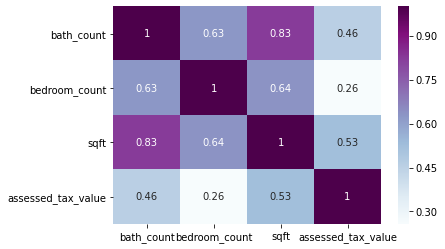

In [67]:
sns.heatmap(mvp_df.corr(), annot=True, cmap="BuPu")

In [68]:
r_bath, p_bath = stats.pearsonr(mvp_df.bath_count, mvp_df.assessed_tax_value)

In [69]:
print(p_bath)

0.0


In [70]:
bedroom_count, p_bedroom_count = stats.pearsonr(mvp_df.bedroom_count, mvp_df.assessed_tax_value)

In [71]:
print(p_bedroom_count)

2.4002008429790452e-147


In [72]:
r_sqft, p_sqft = stats.pearsonr(mvp_df.sqft, mvp_df.assessed_tax_value)

In [73]:
print(p_sqft)

0.0


In [74]:
if p_bath < alpha and p_bedroom_count < alpha and p_sqft < alpha:
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")

We reject the null hypothesis


#### Takeaways on exploration 
- house sqft plays the biggest role in assessed tax value
- bedroom counts and bathroom counts are about the same when it comes to driving assessed tax value

# Modeling
- Establish baseline using the mean assessed_tax_value
- create an OLS model and compare to baseline

In [75]:
X_train = train[["bath_count", "bedroom_count", "sqft"]]
y_train = train.assessed_tax_value

In [76]:
X_train.head()

,bath_count,bedroom_count,sqft
6811,1.0,3.0,1059.0
14770,2.0,4.0,1462.0
8822,2.0,3.0,1258.0
9396,1.0,3.0,1103.0
5697,1.0,2.0,1008.0


In [77]:
y_train.head()

6811     387824.0
14770    441000.0
8822     413368.0
9396     273829.0
5697     148542.0
Name: assessed_tax_value, dtype: float64

- create a dataframe to hold all predictions for easy comparisions later

In [78]:
predictions = pd.DataFrame({"actual": train.assessed_tax_value})

In [79]:
predictions.head()

,actual
6811,387824.0
14770,441000.0
8822,413368.0
9396,273829.0
5697,148542.0


In [80]:
predictions["baseline"] = y_train.mean()

In [81]:
predictions

,actual,baseline
6811,387824.0,409200.635552
14770,441000.0,409200.635552
8822,413368.0,409200.635552
9396,273829.0,409200.635552
5697,148542.0,409200.635552
...,...,...
5653,179543.0,409200.635552
13286,328044.0,409200.635552
1465,251875.0,409200.635552
12639,699000.0,409200.635552


In [82]:
all_3_lm = sklearn.linear_model.LinearRegression()

In [83]:
all_3_lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [84]:
predictions["sqft_nbath_nbed_lm"] = all_3_lm.predict(X_train)

In [85]:
all_3_lm.coef_, all_3_lm.intercept_

(array([ 38695.34391426, -46863.94683727,    189.38263066]), 133679.5413516874)

In [86]:
sqft_x = train[["sqft"]]

In [87]:
sqft_lm = sklearn.linear_model.LinearRegression()

In [88]:
sqft_lm.fit(sqft_x, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [89]:
sqft_lm.coef_, sqft_lm.intercept_

(array([190.41640034]), 64087.71712243208)

In [90]:
predictions["sqft_lm"] = sqft_lm.predict(sqft_x)

In [91]:
n_bed_x = train[["bedroom_count"]]

In [92]:
n_bed_lm = sklearn.linear_model.LinearRegression()

In [93]:
n_bed_lm.fit(n_bed_x, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [94]:
n_bed_lm.coef_, n_bed_lm.intercept_

(array([79589.28477963]), 148561.8514848226)

In [95]:
predictions["n_bed_lm"] = n_bed_lm.predict(n_bed_x)

In [96]:
n_bath_x = train[["bedroom_count"]]

In [97]:
n_bath_lm = sklearn.linear_model.LinearRegression()

In [98]:
n_bath_lm.fit(n_bath_x, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [99]:
n_bath_lm.coef_, n_bath_lm.intercept_

(array([79589.28477963]), 148561.8514848226)

In [100]:
predictions["n_bath_lm"] = n_bed_lm.predict(n_bath_x)

In [101]:
predictions.head()

,actual,baseline,sqft_nbath_nbed_lm,sqft_lm,n_bed_lm,n_bath_lm
6811,387824.0,409200.635552,232339.250627,265738.685086,387329.705824,387329.705824
14770,441000.0,409200.635552,300491.847862,342476.494424,466918.990603,466918.990603
8822,413368.0,409200.635552,308721.738044,303631.548754,387329.705824,387329.705824
9396,273829.0,409200.635552,240672.086377,274117.006701,387329.705824,387329.705824
5697,148542.0,409200.635552,269544.683301,256027.448668,307740.421044,307740.421044


## Evaluate
- Now that I have a predictions table with my actual, baseline and my MVP linear model I can compare the values
- Compare all models against the baseline and each other to determine which performs the best

In [102]:
predictions.apply(lambda col: sqrt(sklearn.metrics.mean_squared_error(predictions.actual, col)))

actual                     0.000000
baseline              277805.682194
sqft_nbath_nbed_lm    233740.061766
sqft_lm               236131.908642
n_bed_lm              268443.475868
n_bath_lm             268443.475868
dtype: float64

In [103]:
mse_all_3 = sklearn.metrics.mean_squared_error(predictions.actual, predictions.sqft_nbath_nbed_lm)

In [104]:
rmse_all_3_lm = sqrt(mse_all_3)

In [105]:
rmse_all_3_lm

233740.06176633752

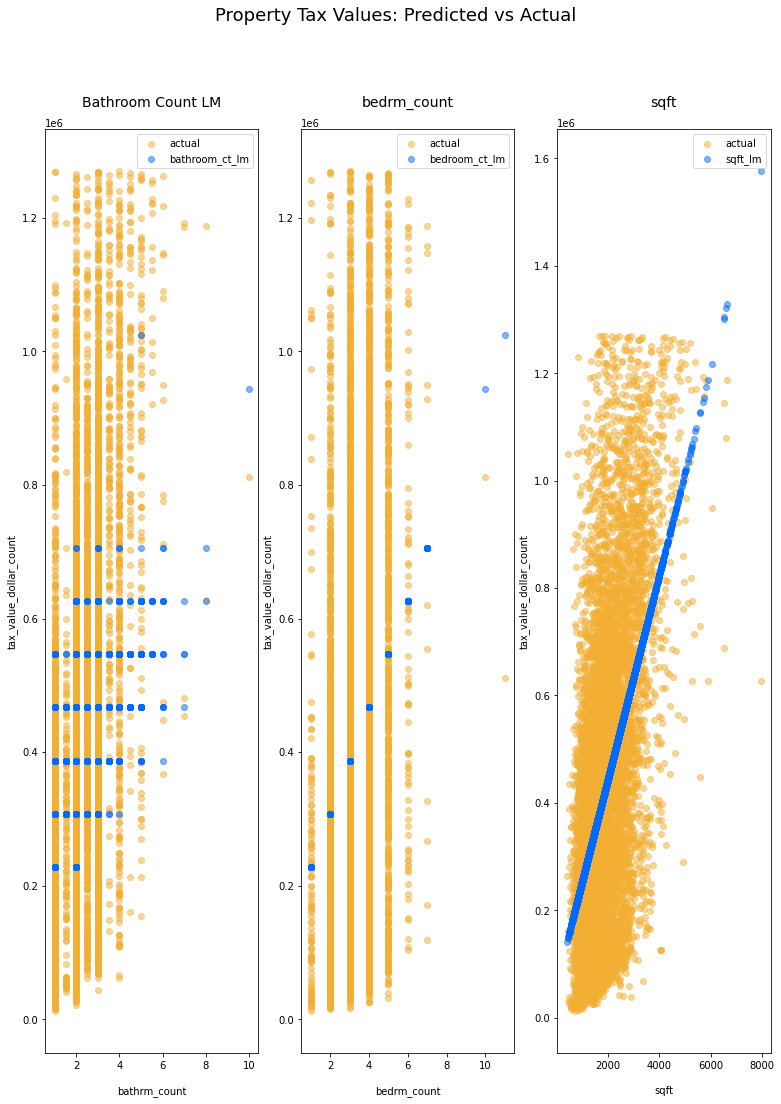

In [106]:
plt.figure(figsize=(13,17))
plt.suptitle('Property Tax Values: Predicted vs Actual\n', fontsize=18)
# Figure 1
plt.subplot(1, 3, 1)
plt.title('Bathroom Count LM\n', fontsize=14)
plt.scatter(X_train.bath_count, y_train, label='actual',alpha=0.5, c="#f2af34ff")
plt.scatter(X_train.bath_count, predictions.n_bath_lm , label='bathroom_ct_lm', alpha=0.5, c="#006AFF")
plt.xlabel('\nbathrm_count')
plt.ylabel('tax_value_dollar_count')
plt.legend()
# Figure 2
plt.subplot(1, 3, 2)
plt.title('bedrm_count\n', fontsize=14)
plt.scatter(X_train.bedroom_count, y_train, label='actual', alpha=0.5, c="#f2af34ff")
plt.scatter(X_train.bedroom_count, predictions.n_bed_lm, label='bedroom_ct_lm',alpha=0.5, c="#006AFF")
plt.xlabel('\nbedrm_count')
plt.ylabel('tax_value_dollar_count')
plt.legend()
# Figure 3
plt.subplot(1, 3, 3)
plt.title('sqft\n', fontsize=14)
plt.scatter(X_train.sqft, y_train, label='actual', alpha=0.5, c="#f2af34ff")
plt.scatter(X_train.sqft, predictions.sqft_lm, label='sqft_lm', alpha=0.5, c="#006AFF")
plt.xlabel('\nsqft')
plt.ylabel('tax_value_dollar_count')
plt.legend()
plt.show()

/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/relational.py:784: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  line, = ax.plot([], [], **kws)
/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/relational.py:795: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  line, = ax.plot(x, y, **kws)
/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/relational.py:784: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  line, = ax.plot([], [], **kws)
/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/relational.py:795: MatplotlibD

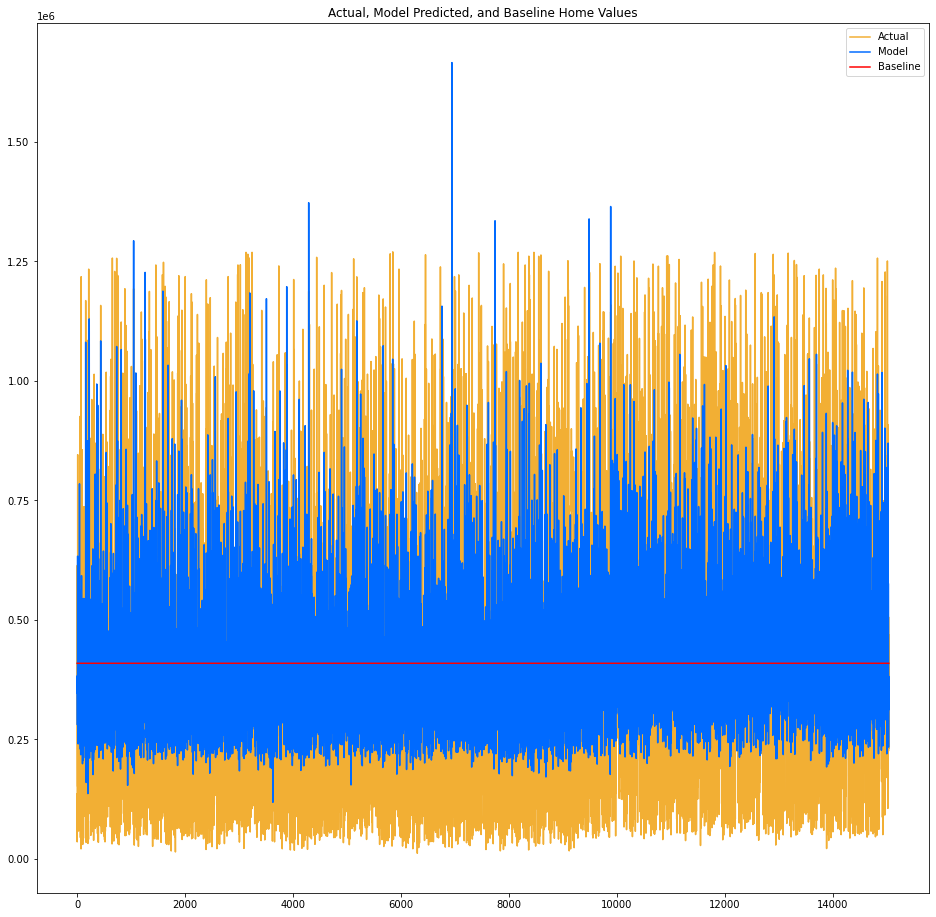

In [113]:
plt.figure(figsize=(16, 16))
plt.title("Actual, Model Predicted, and Baseline Home Values")
sns.lineplot(data=predictions.actual, label="Actual", c="#f2af34ff")
sns.lineplot(data=predictions.sqft_nbath_nbed_lm, label="Model", c="#006AFF")
sns.lineplot(data=predictions.baseline, label="Baseline", c="red")

Text(0.5, 1.0, 'Predicted vs Actual')

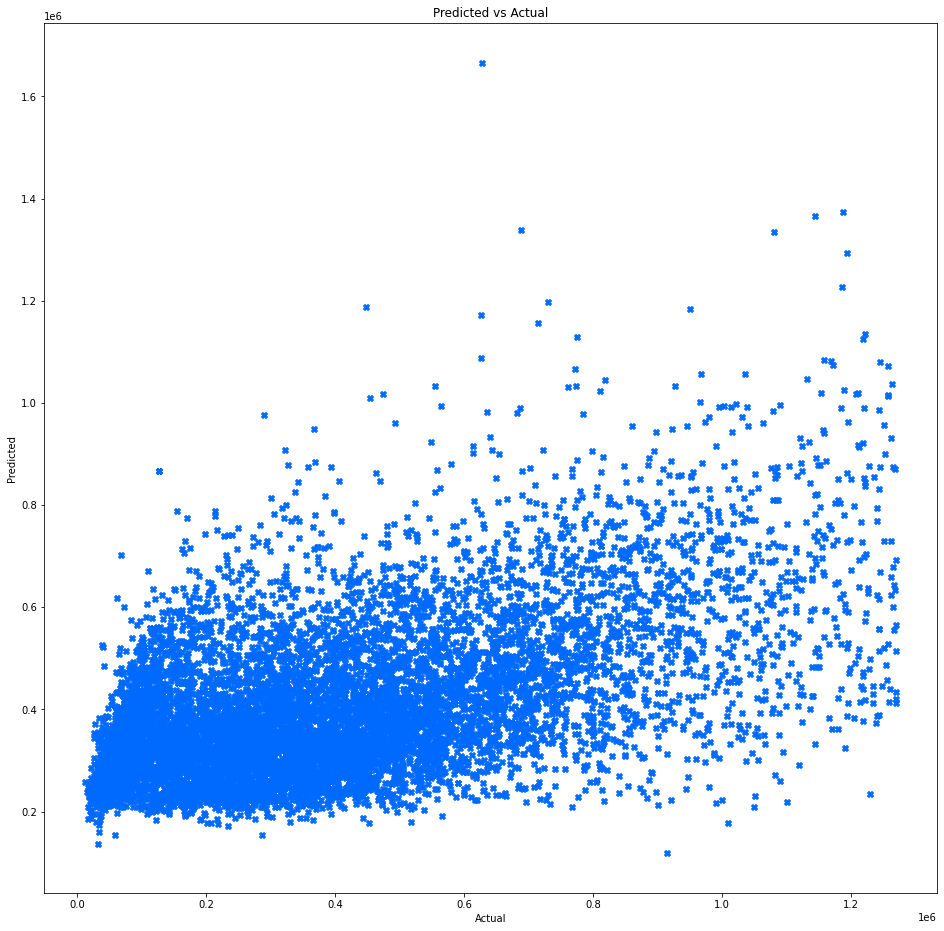

In [108]:
plt.figure(figsize=(16, 16))

plt.scatter(predictions.actual, predictions.sqft_nbath_nbed_lm, label='LinearRegression (assessed_tax_value ~ sqft, bedroom_count, bath_count)', marker='X', c="#006AFF")

plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Predicted vs Actual')

In [109]:
def plot_residuals(actual, predicted, plot_title='Predicted vs Actual'):
    """
    Takes in two values and plots the residuals
    also takes in a plot title string, defaults to Predicted VS Actual if not provided
    """
    residuals = actual - predicted
    plt.figure(figsize=(16, 12))
    plt.hlines(0, actual.min(), actual.max(), ls=':')
    plt.scatter(actual, residuals, c="#006AFF", alpha=0.5)
    plt.ylabel('residual ($y - \hat{y}$)')
    plt.xlabel('actual value ($y$)')
    plt.title(plot_title)
    return plt.gca()

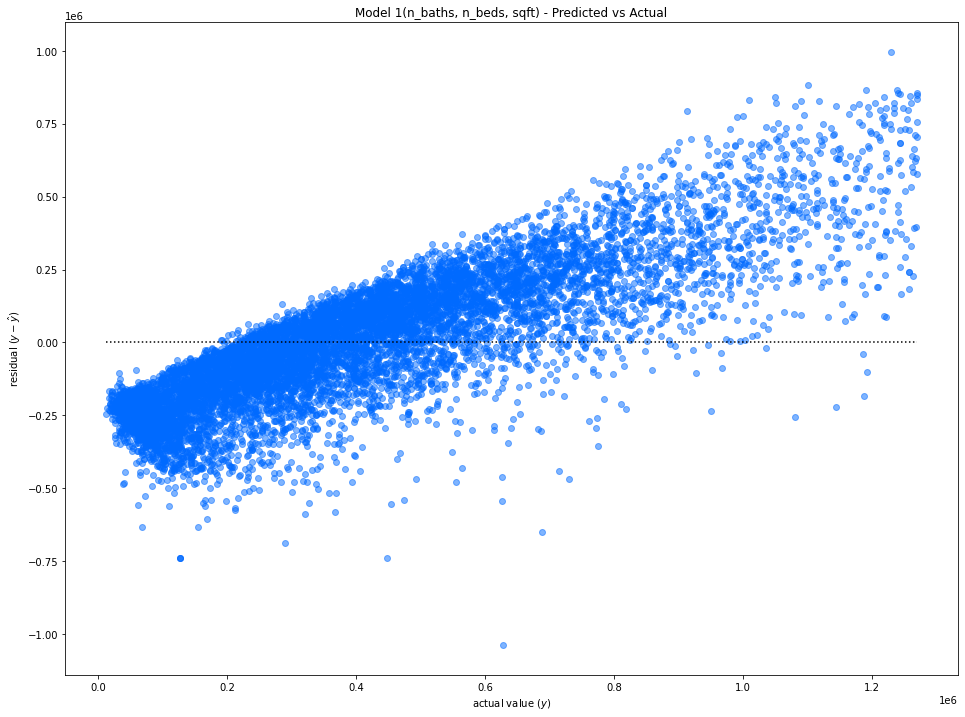

In [110]:
plot_residuals(predictions.actual, predictions.sqft_nbath_nbed_lm, "Model 1(n_baths, n_beds, sqft) - Predicted vs Actual")

In [111]:
predictions.head()

,actual,baseline,sqft_nbath_nbed_lm,sqft_lm,n_bed_lm,n_bath_lm
6811,387824.0,409200.635552,232339.250627,265738.685086,387329.705824,387329.705824
14770,441000.0,409200.635552,300491.847862,342476.494424,466918.990603,466918.990603
8822,413368.0,409200.635552,308721.738044,303631.548754,387329.705824,387329.705824
9396,273829.0,409200.635552,240672.086377,274117.006701,387329.705824,387329.705824
5697,148542.0,409200.635552,269544.683301,256027.448668,307740.421044,307740.421044


Text(0.5, 1.0, 'Model for: Bathroom count')

<Figure size 432x288 with 0 Axes>

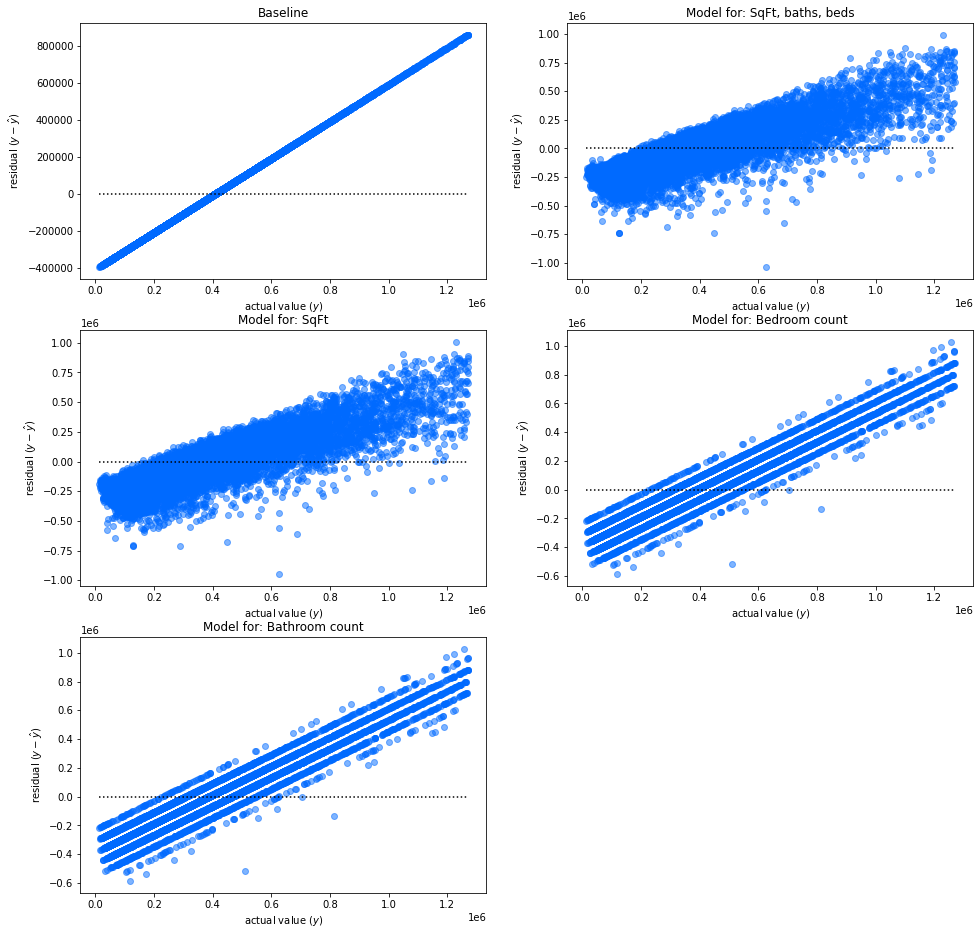

In [112]:
plt.suptitle('Residuals for all Models\n', fontsize=18)
plt.figure(figsize=(16, 16))
residual_bl = predictions.actual - predictions.baseline
residual_all3_lm = predictions.actual - predictions.sqft_nbath_nbed_lm
residual_sqft_lm = predictions.actual - predictions.sqft_lm
residual_n_bed_lm = predictions.actual - predictions.n_bed_lm
residual_n_bath_lm= predictions.actual - predictions.n_bath_lm

#baseline
plt.subplot(3, 2, 1)
plt.hlines(0, predictions.actual.min(), predictions.actual.max(), ls=':')
plt.scatter(predictions.actual, residual_bl, c="#006AFF", alpha=0.5)
plt.ylabel('residual ($y - \hat{y}$)')
plt.xlabel('actual value ($y$)')
plt.title("Baseline")

#All 3 features lm
plt.subplot(3, 2, 2)
plt.hlines(0, predictions.actual.min(), predictions.actual.max(), ls=':')
plt.scatter(predictions.actual, residual_all3_lm, c="#006AFF", alpha=0.5)
plt.ylabel('residual ($y - \hat{y}$)')
plt.xlabel('actual value ($y$)')
plt.title("Model for: SqFt, baths, beds")

# SqFt lm
plt.subplot(3, 2, 3)
plt.hlines(0, predictions.actual.min(), predictions.actual.max(), ls=':')
plt.scatter(predictions.actual, residual_sqft_lm, c="#006AFF", alpha=0.5)
plt.ylabel('residual ($y - \hat{y}$)')
plt.xlabel('actual value ($y$)')
plt.title("Model for: SqFt")

# Number of beds lm
plt.subplot(3, 2, 4)
plt.hlines(0, predictions.actual.min(), predictions.actual.max(), ls=':')
plt.scatter(predictions.actual, residual_n_bed_lm, c="#006AFF", alpha=0.5)
plt.ylabel('residual ($y - \hat{y}$)')
plt.xlabel('actual value ($y$)')
plt.title("Model for: Bedroom count")

# Number of bath lm
plt.subplot(3, 2, 5)
plt.hlines(0, predictions.actual.min(), predictions.actual.max(), ls=':')
plt.scatter(predictions.actual, residual_n_bath_lm, c="#006AFF", alpha=0.5)
plt.ylabel('residual ($y - \hat{y}$)')
plt.xlabel('actual value ($y$)')
plt.title("Model for: Bathroom count")

